In [1]:
import glob
import librosa
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_speaker_id_gender(file):
    """
    Extracts speaker IDs and genders from an input file containing speaker information.

    Parameters:
        file (str): Path to the input file containing speaker information.

    Returns:
        tuple: A tuple containing two lists - speaker IDs and genders.
               - The first list contains speaker IDs.
               - The second list contains corresponding genders.
    """

    id_speaker = []   # List to store speaker IDs
    gender_speaker = []   # List to store speaker genders

    # Read the information from the input file
    with open(file) as f:
        info_file = f.readlines()

    # Process each line in the file
    for line in info_file:
        if not line.startswith(';'):   # Skip lines starting with ';'
            data_speaker = line.split('|')   # Split the line based on '|'
            set_speaker = data_speaker[2].strip()   # Get the speaker set

            if 'dev-clean' in set_speaker:
                # Add speaker ID and gender to the respective lists
                id_speaker.append(data_speaker[0].strip())
                gender_speaker.append(data_speaker[1].strip())

    return id_speaker, gender_speaker


In [4]:
def librosa_load(f, sr=16000, offset=None, duration=None):
    """
    Load an audio file using librosa with optional parameters for offset and duration.

    Parameters:
        f (str): File path to the audio file.
        sr (int, optional): Sampling rate for the audio. Defaults to 16000.
        offset (float, optional): Start time (in seconds) for audio loading. Defaults to None.
        duration (float, optional): Duration (in seconds) of audio to load. Defaults to None.

    Returns:
        tuple: A tuple containing audio data and the sampling rate.
               - The first element is the audio data.
               - The second element is the sampling rate.
    """

    if offset is not None and duration is not None and sr is not None:
        # Load audio with specified sampling rate, offset, and duration
        return librosa.load(f, sr=sr, offset=offset, duration=duration)
    else:
        # Load audio with specified sampling rate
        return librosa.load(f, sr=sr)


In [5]:
def extract_feat(filename):
    """
    Extract MFCC (Mel-Frequency Cepstral Coefficients) features from an audio file.

    Parameters:
        filename (str): File path to the audio file.

    Returns:
        numpy.ndarray: 13 MFCC features of the audio.
    """

    audio, sample_rate = librosa_load(filename)  # Load audio using librosa_load

    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

    return mfcc_features

In [6]:
def get_feat_labels(file_path):
    """
    Extract MFCC features from audio files for each speaker, along with speaker IDs and gender.
    Save the features, speaker IDs, and gender to a DataFrame and pickle the DataFrame to a file.

    Parameters:
        file_path (str): Path to save the pickled DataFrame.

    Returns:
        None
    """

    # Paths and data for audio and speakers
    dir = '/content/drive/MyDrive/dev-clean'
    speakers = '/content/drive/MyDrive/SPEAKERS.TXT'

    # Get speaker IDs and gender from the provided speakers file
    id_speaker, gender_speaker = get_speaker_id_gender(speakers)

    # List of column names for the DataFrame
    column_names = ['MFCC_0', 'MFCC_1', 'MFCC_2', ..., 'MFCC_12', 'Speaker_ID', 'Gender', 'Audio']

    # Initialize an empty DataFrame with the specified column names
    df_final = pd.DataFrame(columns=column_names)

    # Iterate through each speaker
    for index, id in enumerate(id_speaker):
        print(id)

        # Get the audio files for the current speaker
        dir_audios = dir + '/' + id + '/*/*.flac'
        file_list = glob.glob(dir_audios)

        # Iterate through each audio file for the current speaker
        for audio in file_list:
            # Extract MFCC features from the audio file
            mfccs_audio = extract_feat(audio)
            transposed_mfcc = mfccs_audio.T

            # Create a DataFrame for the MFCC features
            df_mfcc = pd.DataFrame(transposed_mfcc, columns=[f'MFCC_{i}' for i in range(13)])

            # Create an auxiliary DataFrame with Speaker_ID, Gender, and Audio information
            aux_df = pd.DataFrame({
                'Speaker_ID': [id] * transposed_mfcc.shape[0],
                'Gender': [gender_speaker[index]] * transposed_mfcc.shape[0],
                'Audio': [audio] * transposed_mfcc.shape[0]
            })

            # Concatenate the MFCC DataFrame and the auxiliary DataFrame
            df_result = pd.concat([df_mfcc, aux_df], axis=1)

            # Concatenate the result with the final DataFrame
            df_final = pd.concat([df_result, df_final])

    # Save the final DataFrame to a pickle file
    with open(file_path, 'wb') as file:
        pickle.dump(df_final, file)

In [7]:
# Define the file path for the pickle file
file_path = '/content/drive/MyDrive/pandas_dataframe_audio.pkl'

# Check if the file at the specified file_path exists
if os.path.exists(file_path):
    # If the file exists, load the data from the pickle file
    print('File exists, load data')
    with open(file_path, 'rb') as file:
        df = pickle.load(file)
else:
    # If the file doesn't exist, print a message and extract features
    print('File does not exist. Extract features')
    get_feat_labels(file_path)

File exists, load data


**Data Visualization of the mfccs from the audios extracted**

In [8]:
def get_mfcc_for_audio(df,gender):
  """
    Retrieve MFCC features for an audio of the specified gender from the given DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features, speaker IDs, genders, and audio paths.
        gender (str): Gender to filter the DataFrame.

    Returns:
        numpy.ndarray: MFCC features for a randomly selected audio of the specified gender.
                        Rows represent each MFCC coefficient, and columns represent samples.
    """

  # Randomly sample an audio for the specified gender
  sample_data = df[df['Gender'] == gender].sample(n=1)
  audio_sample = sample_data['Audio'].values[0]
  speaker_id = sample_data['Speaker_ID'].values[0]

  # Filter the DataFrame for the specified audio sample and gender
  filtered_data = df[(df['Audio'] == audio_sample) & (df['Gender'] == gender) & (df['Speaker_ID'] == speaker_id)]

  # Initialize an array to store MFCC features
  mfcc_matrix = np.zeros((13, len(filtered_data)))

  # Fill the MFCC matrix with MFCC coefficients
  for i in range(13):
      mfcc_matrix[i, :] = filtered_data[f'MFCC_{i}'].to_numpy()

  return mfcc_matrix

In [10]:
def plot_mfccs_gender(df):
    """
    Plot MFCC features for both female and male genders.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features, speaker IDs, genders, and audio paths.

    Returns:
        None
    """

    # Retrieve MFCC features for female and male genders for one audio sample
    mfcc_female = get_mfcc_for_audio(df, 'F')
    mfcc_male = get_mfcc_for_audio(df, 'M')

    # Plot the MFCC features for female and male in subplots
    plt.subplot(1, 2, 1)  # row 1, col 2 index 1
    librosa.display.specshow(mfcc_female)
    plt.ylabel('MFCC female')
    plt.xlabel('Time')
    plt.colorbar()

    plt.subplot(1, 2, 2)  # index 2
    librosa.display.specshow(mfcc_male)
    plt.ylabel('MFCC male')
    plt.xlabel('Time')
    plt.colorbar()

    plt.show()


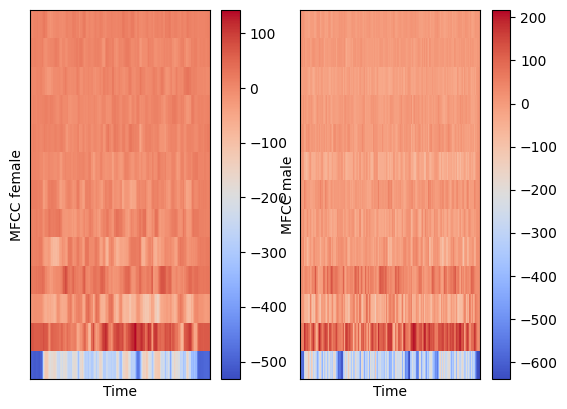

In [ ]:
plot_mfccs_gender(df)

In [11]:
def plot_boxplot_or_violinplot(df, keyword):
    """
    Plot boxplot or violin plot for MFCC coefficients by gender.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features and gender information.
        keyword (str): Keyword indicating the type of plot ('violin' or 'boxplot').

    Returns:
        None
    """

    # Extract MFCC columns and gender from the DataFrame
    mfcc_columns = [f'MFCC_{i}' for i in range(13)]
    mfcc_data = df[mfcc_columns + ['Gender']]

    # Transform the DataFrame for suitable plotting
    mfcc_data_plot = mfcc_data.melt(id_vars='Gender', value_vars=mfcc_columns, var_name='MFCC', value_name='MFCC Value')

    if keyword in 'violin':
        # Plot a violin plot for MFCC values by gender
        plt.figure(figsize=(15, 8))
        sns.violinplot(x='MFCC', y='MFCC Value', hue='Gender', data=mfcc_data_plot, split=True, inner='quartile')
        plt.title('Violin Plot of MFCCs for Male and Female Speakers')

    elif keyword in 'boxplot':
        # Plot a boxplot for MFCC values by gender
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='MFCC', y='MFCC Value', hue='Gender', data=mfcc_data_plot, palette='Set2')
        plt.title('Box Plots of MFCCs for Male and Female Speakers')
        plt.legend(title='Gender', loc='upper right')
        plt.tight_layout()

    plt.xlabel('MFCC Coefficients')
    plt.ylabel('MFCC Values')
    plt.xticks(rotation=45)
    plt.show()

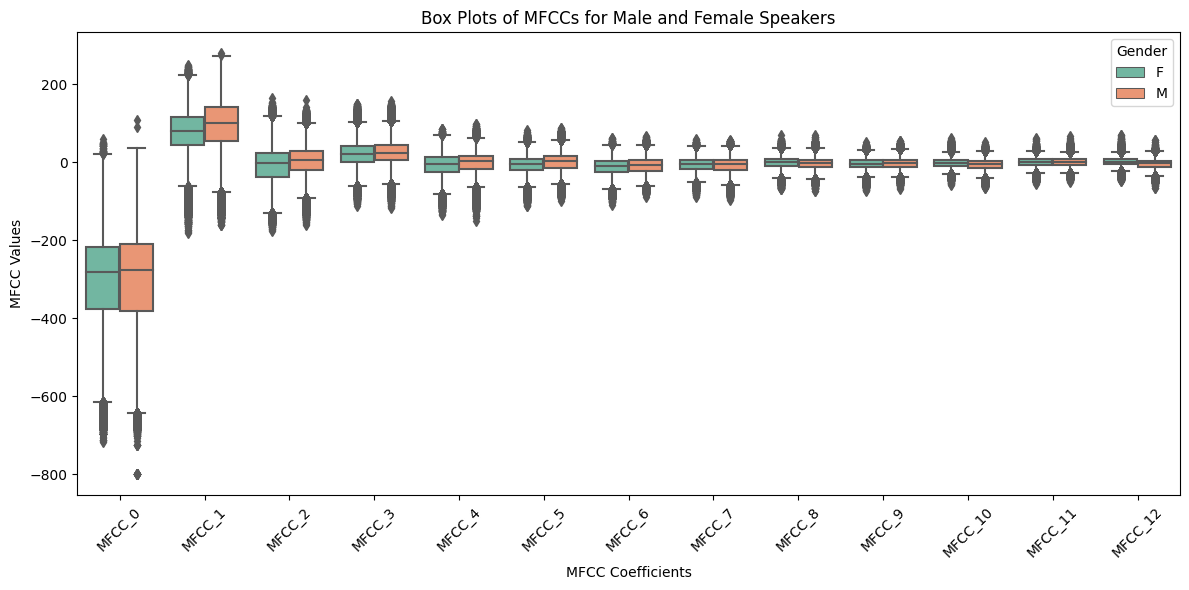

In [ ]:
plot_boxplot_or_violinplot(df,'boxplot')

In [12]:
def calculate_mean_std_per_audio(df):
    """
    Calculate mean and standard deviation of MFCCs for each audio, gender, and speaker.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features, speaker IDs, genders, and audio paths.

    Returns:
        pd.DataFrame: DataFrame with mean and standard deviation of MFCCs per audio, gender, and speaker.
    """

    # Group by 'Audio', 'Gender', and 'Speaker_ID' and calculate mean and std for MFCCs
    mfcc_mean_std = df.groupby(['Audio', 'Gender', 'Speaker_ID']).agg({
        **{f'MFCC_{i}': ['mean', 'std'] for i in range(13)}}
    )

    # Flatten the column names for easier use
    mfcc_mean_std.columns = ['_'.join(col).strip() for col in mfcc_mean_std.columns.values]

    # Reset index to make 'Audio', 'Gender', and 'Speaker_ID' as regular columns
    mfcc_mean_std.reset_index(inplace=True)

    # Return the resulting DataFrame with mean and standard deviation of MFCCs
    return mfcc_mean_std


In [ ]:
mfcc_mean_std = calculate_mean_std_per_audio(df)

In [13]:
def plot_hists(df, keyword):
    """
    Plot histograms of MFCCs for male and female speakers.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features, speaker IDs, genders, and audio paths.
        keyword (str): Keyword indicating the type of MFCC representation ('per_frame' or 'per_audio').

    Returns:
        None
    """

    # List of MFCC column names based on the keyword
    if 'per_frame' in keyword:
        mfcc_columns = [f'MFCC_{i}' for i in range(13)]
    elif 'per_audio' in keyword:
        mfcc_columns = [f'MFCC_{i}_mean' for i in range(13)] + [f'MFCC_{i}_std' for i in range(13)]

    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15, 20))

    fig.suptitle('Histograms of MFCCs for Male and Female')

    for i, ax in enumerate(axes.flat):
        if i < len(mfcc_columns):
            mfcc_column = mfcc_columns[i]
            ax.hist(df[df['Gender'] == 'M'][mfcc_column], alpha=0.5, label='Male', color='blue', bins=30)
            ax.hist(df[df['Gender'] == 'F'][mfcc_column], alpha=0.5, label='Female', color='orange', bins=30)
            ax.set_xlabel('MFCC Value')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{mfcc_column}')
            ax.legend()

    # Hide empty subplots if any
    for i in range(len(mfcc_columns), len(axes.flat)):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


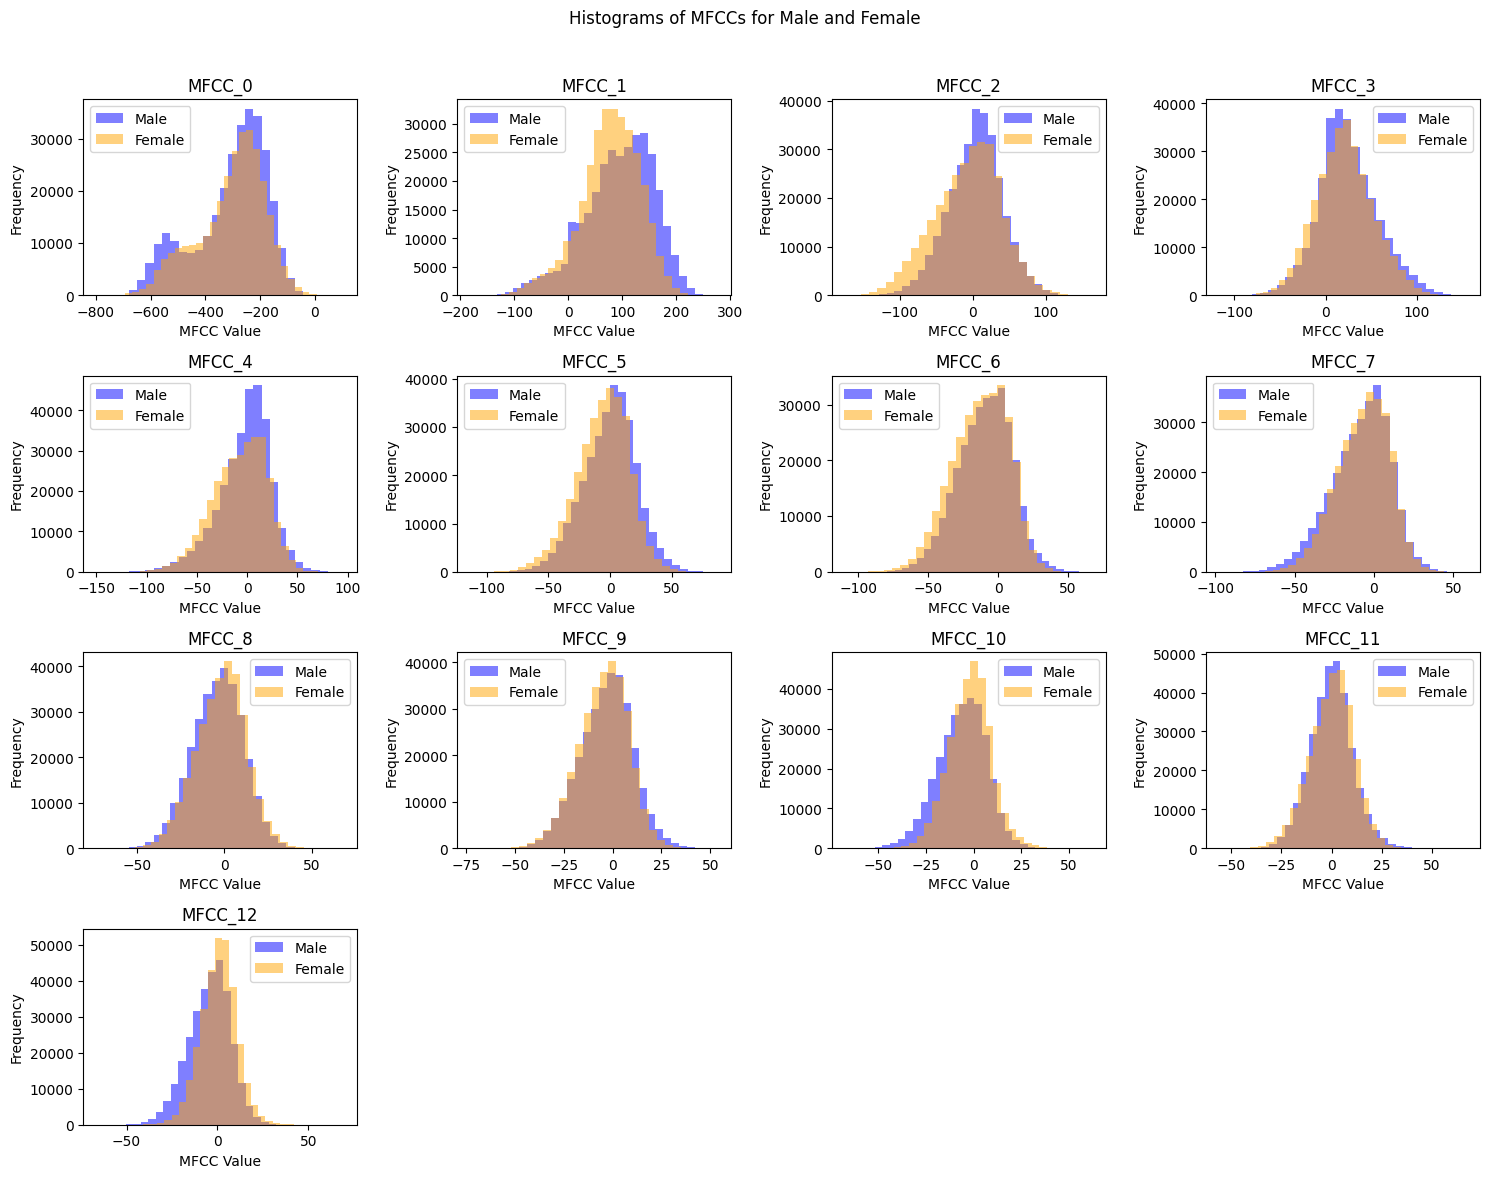

In [ ]:
plot_hists(df,'per_frame')

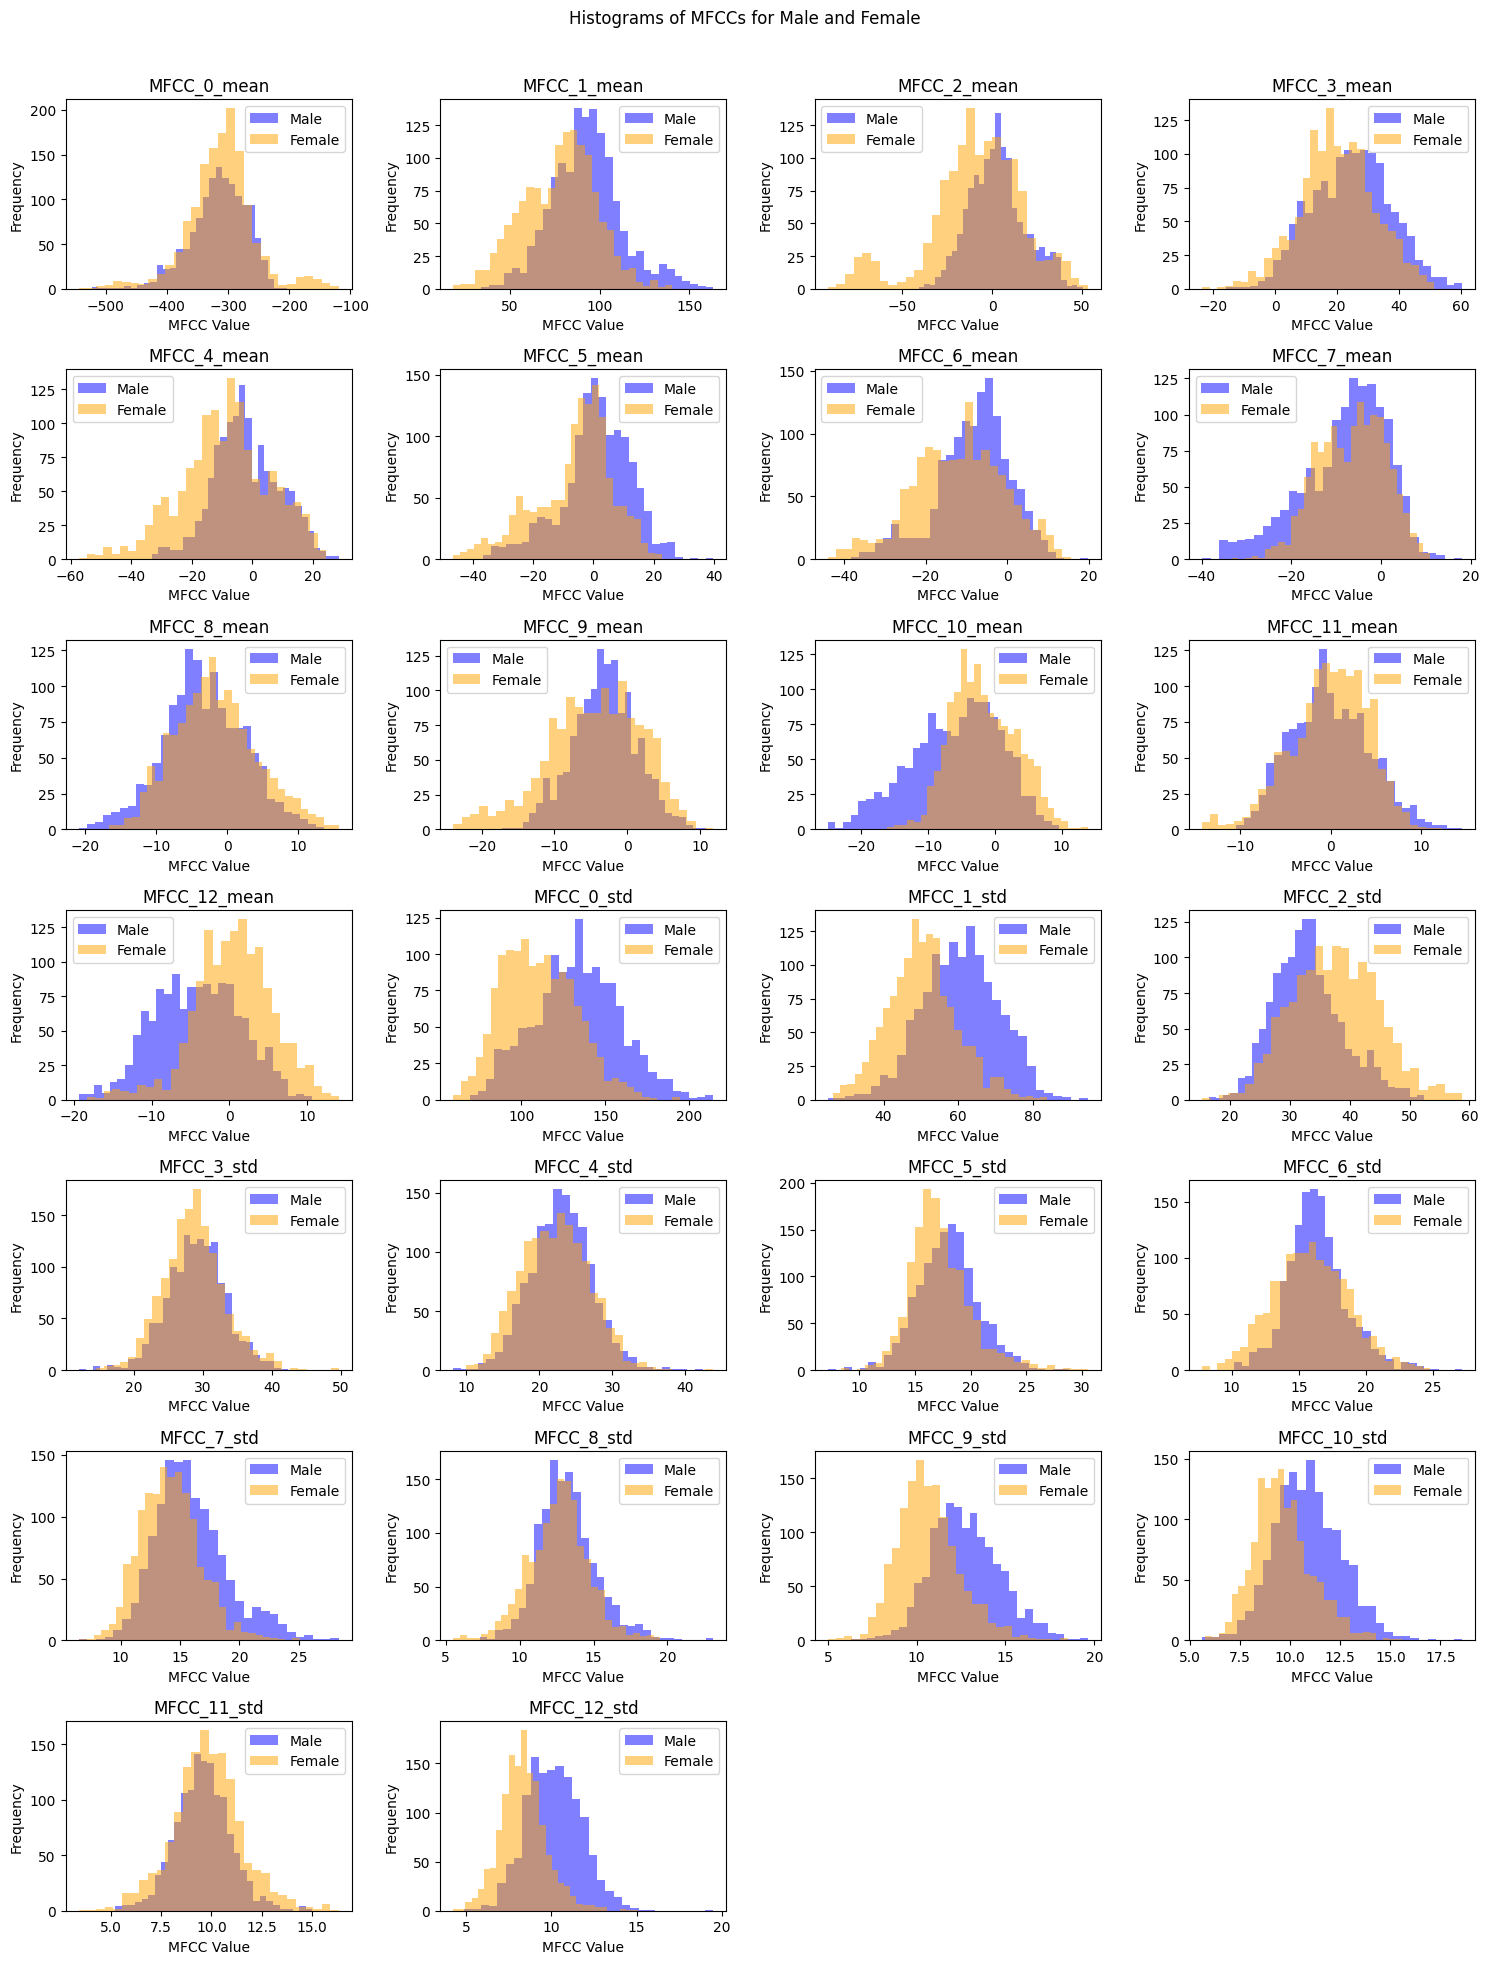

In [ ]:
plot_hists(mfcc_mean_std,'per_audio')

**Comments on Data Visualization:**
We computed the 13 MFCC coefficients for each frame across all available audio samples. Subsequently, we generated box plots for these coefficients, categorizing them by gender. Additionally, histograms were plotted to visualize the distribution. The first set of histograms represents the mean and standard deviation for each MFCC, calculated per audio and segregated by gender. In the second set of histograms we show the values of the MFCC coefficients for each frame.
We observed that while some coefficients exhibit similar distributions, others showcase significant differences. For instance, in the first set of histograms, we can focus on MFCC number 1, where we notice distinct value distributions for both males and females. This observation suggests that the 13 selected MFCCs possess adequate differences between females and males for the chosen models to capture effectively.






**Outlier detection: implementing two different techniques, z-score and Inter Quartile Range(IQR)**

In [14]:
def calculate_zcore(df):
    """
    Calculate z-scores for MFCC dimensions and identify outliers based on a specified threshold.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features.

    Returns:
        None
    """

    # Extract MFCC column names
    mfcc_columns = [f'MFCC_{i}' for i in range(13)]

    # Extract MFCC data from the DataFrame
    mfcc_data = df[mfcc_columns]

    # Calculate z-scores for each MFCC dimension
    z_scores = (mfcc_data - mfcc_data.mean()) / mfcc_data.std()

    # Define a threshold for outlier detection (e.g., z-score > 3)
    threshold = 3

    # Mark outliers (True if the z-score exceeds the threshold, indicating an outlier)
    outliers = np.abs(z_scores) > threshold

    # Print the count of outliers for each MFCC dimension
    print("Count of outliers for each MFCC:")
    print(outliers.sum())

    # Mark rows with any outlier (True if any MFCC dimension is an outlier)
    df['Is_Outlier'] = outliers.any(axis=1)

    # Filter the DataFrame to exclude rows with outliers
    df_filtered = df[~df['Is_Outlier']]

In [15]:
calculate_zcore(df)

Count of outliers for each MFCC:
MFCC_0       80
MFCC_1     2332
MFCC_2     1857
MFCC_3     1943
MFCC_4     3455
MFCC_5     2672
MFCC_6     1558
MFCC_7     2619
MFCC_8     1640
MFCC_9     2359
MFCC_10    3514
MFCC_11    2916
MFCC_12    3279
dtype: int64


In [16]:
def calculate_outliers_iqr(df):
    """
    Calculate outliers for MFCC dimensions using the Interquartile Range (IQR) method.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing MFCC features.

    Returns:
        None
    """

    # Select only the MFCC columns
    mfcc_columns = [f'MFCC_{i}' for i in range(13)]
    mfcc_data = df[mfcc_columns]

    # Calculate the first quartile (Q1)
    Q1 = mfcc_data.quantile(0.25)

    # Calculate the third quartile (Q3)
    Q3 = mfcc_data.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = (mfcc_data < lower_bound) | (mfcc_data > upper_bound)

    # Print the count of outliers for each MFCC dimension
    print("Count of outliers for each MFCC:")
    print(outliers.sum())

    # Add a new column to the DataFrame to indicate if a row is an outlier
    df['Is_Outlier'] = outliers.any(axis=1)

    # Filter the DataFrame to exclude rows with outliers
    df_filtered = df[~df['Is_Outlier']]

In [17]:
calculate_outliers_iqr(df)

Count of outliers for each MFCC:
MFCC_0     4607
MFCC_1     7940
MFCC_2     6680
MFCC_3     8135
MFCC_4     7602
MFCC_5     7054
MFCC_6     3061
MFCC_7     5477
MFCC_8     3817
MFCC_9     5391
MFCC_10    8252
MFCC_11    7826
MFCC_12    9336
dtype: int64


**Comments on outlier detection:**

The counts of outliers vary notably between the z-score and IQR methods for each MFCC, indicating differing sensitivity levels to outliers. Nevertheless, certain coefficients consistently exhibit a high number of outliers across both methods. This suggests that these coefficients may have a lower impact when training a model.

**Normalization of the mfccs:**
Global cepstral mean and variance normalization(CMVN)



In [18]:
def perform_cmvn(df, mfcc_columns):
    """
    Perform Cepstral Mean and Variance Normalization (CMVN) on specified MFCC columns of a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        mfcc_columns (list): List of MFCC column names to perform CMVN on.

    Returns:
        pd.DataFrame: DataFrame with CMVN applied to specified MFCC columns.
    """
    df_normalized = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for col in mfcc_columns:
        # Calculate mean and variance for the current column
        mean = df[col].mean()
        variance = df[col].var()

        # Perform mean normalization
        df_normalized[col] = df[col] - mean

        # Perform variance normalization
        epsilon = 1e-10  # Small constant to prevent division by zero
        df_normalized[col] = df_normalized[col] / (np.sqrt(variance) + epsilon)

    return df_normalized


# Columns to apply CMVN (MFCC features)
mfcc_columns = [f'MFCC_{i}' for i in range(13)]

# Perform CMVN on specified MFCC columns
df_normalized = perform_cmvn(df, mfcc_columns)

In [19]:
# Extract the normalized MFCC features (X_norm) and gender labels (y_norm)
X_norm = df_normalized[[f'MFCC_{i}' for i in range(13)]].values  # Extract normalized MFCC features
y_norm = df_normalized['Gender'].values  # Extract gender labels (target variable)
all_audios_ids = df_normalized['Audio'].values  # Extract gender labels (target variable)

We will be dividing our data in 80% train and 20% test and we are ploting the number of female and males samples in each one of the sets to ensure that we have an equal representation between the two in both sets, if not we should look for another set.

In [20]:
def check_distribution_labels(y_train, y_test, tolerance):
    """
    Check the distribution of labels (e.g., gender) in training and testing sets.

    Parameters:
        y_train (numpy.ndarray): Labels for the training set.
        y_test (numpy.ndarray): Labels for the testing set.
        tolerance (float): Tolerance threshold for label distribution.

    Returns:
        bool: True if label distribution is within the tolerance, False otherwise.
    """

    # Calculate the counts of each class in y_train
    train_count_male = np.sum(y_train == 'M')
    train_count_female = np.sum(y_train == 'F')

    # Calculate the counts of each class in y_test
    test_count_male = np.sum(y_test == 'M')
    test_count_female = np.sum(y_test == 'F')

    # Calculate the percentage of males in training and testing sets
    perc_train_male = train_count_male / (train_count_male + train_count_female)
    perc_test_male = test_count_male / (test_count_male + test_count_female)

    # Check if the percentage of males is within the tolerance for both training and testing sets
    if perc_train_male < tolerance or perc_test_male < tolerance:
        return False
    else:
        return True


In [21]:
from sklearn.model_selection import train_test_split

pickle_file_path = "/content/drive/MyDrive/x_train_x_test.pickle"

if not os.path.exists(pickle_file_path):
  print('Does not exist. Split the data')
  # Initial split
  X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=None, shuffle=True)

  # Check the distribution and re-split if needed
  if not check_distribution_labels(y_train, y_test, 0.4):
      while not check_distribution_labels(y_train, y_test):
          X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=None, shuffle=True)

  # Save the split data into a pickle file
  with open(pickle_file_path, 'wb') as pickle_file:
      pickle.dump((X_train, X_test, y_train, y_test), pickle_file)
else:
  # Load the split data from the pickle file
  print('Already exists.Load data.')
  with open(pickle_file_path, 'rb') as pickle_file:
      X_train, X_test, y_train, y_test = pickle.load(pickle_file)

Already exists.Load data.


In [22]:
from sklearn.model_selection import train_test_split

pickle_file_path = "/content/drive/MyDrive/trial.pickle"

if not os.path.exists(pickle_file_path):
    print('Does not exist. Split the data')

    # Get the indices of the original X_norm
    indices = range(len(X_norm))

    # Initial split
    indices_train, indices_test, y_train, y_test = train_test_split(indices, y_norm, test_size=0.2, random_state=None, shuffle=True)

    # Use the obtained indices to extract X_train and X_test
    X_train = X_norm[indices_train]
    X_test = X_norm[indices_test]

    # Check the distribution and re-split if needed
    if not check_distribution_labels(y_train, y_test, 0.4):
        while not check_distribution_labels(y_train, y_test):
            indices_train, indices_test, y_train, y_test = train_test_split(indices, y_norm, test_size=0.2, random_state=None, shuffle=True)
            X_train = X_norm[indices_train]
            X_test = X_norm[indices_test]

    # Save the split data and indices into a pickle file
    with open(pickle_file_path, 'wb') as pickle_file:
        pickle.dump((X_train, X_test, y_train, y_test, indices_train, indices_test), pickle_file)
else:
    # Load the split data and indices from the pickle file
    print('Already exists. Load data.')
    with open(pickle_file_path, 'rb') as pickle_file:
        X_train, X_test, y_train, y_test, indices_train, indices_test = pickle.load(pickle_file)


Already exists. Load data.


In [30]:
from collections import Counter

def get_y(audio_ids_test, y_pred):
    """
    Predicts the gender for each unique audio ID based on the most frequently predicted gender.

    Parameters:
        audio_ids_test (list): A list of audio IDs corresponding to the samples.
        y_pred (list): A list of predicted genders for each sample.

    Returns:
        list: A list of tuples, each containing an audio ID and the most common predicted gender for that audio.
    """

    # Create a dictionary to store predicted genders for each audio ID and count them
    audio_to_predicted_gender_count = {}

    # Iterate through the audio IDs and corresponding predicted genders
    for audio_id, predicted_gender in zip(audio_ids_test, y_pred):
        if audio_id not in audio_to_predicted_gender_count:
            # If the audio ID is not in the dictionary, create a new entry
            audio_to_predicted_gender_count[audio_id] = Counter()

        # Count the predicted gender for this audio
        audio_to_predicted_gender_count[audio_id][predicted_gender] += 1

    # Initialize a list to store the final predicted genders for each audio ID
    final_predicted_genders_per_audio = []

    # Iterate through the unique audio IDs and determine the most common predicted gender for each audio ID
    unique_audio_ids = set(audio_ids_test)  # Get unique audio IDs
    for audio_id in unique_audio_ids:
        # Get the most common predicted gender for this audio
        most_common_gender = audio_to_predicted_gender_count[audio_id].most_common(1)[0][0]
        final_predicted_genders_per_audio.append( most_common_gender)

    # Now final_predicted_genders_per_audio contains the predicted gender for each unique audio ID in the test set

    return final_predicted_genders_per_audio

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_acc_recall_prec_conf_matrix(y_pred, y_true):
    """
    Compute accuracy, precision, recall, and confusion matrix based on predicted and true labels.

    Parameters:
    y_pred (array-like): Predicted class labels.
    y_true (array-like): True class labels.

    Returns:
    None: Prints the computed metrics and confusion matrix.
    """

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute precision
    precision = precision_score(y_true, y_pred)

    # Compute recall
    recall = recall_score(y_true, y_pred)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print the computed metrics and confusion matrix
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Confusion Matrix:")
    print(conf_matrix)

First classifier: GradientBooster

In [25]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder

# Creating a LabelEncoder instance
label_encoder = LabelEncoder()

# Fitting the LabelEncoder on training and test labels to learn the mapping
label_encoder.fit(y_train)

# Encoding categorical labels for the test and training set
y_train_gb = label_encoder.transform(y_train)
y_test_gb = label_encoder.transform(y_test)

In [26]:
# Import necessary library for Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting model
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train_gb)

# Display information about the trained Gradient Boosting model
print("Gradient Boosting")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train_gb)))  # Print training set accuracy
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test_gb)))  # Print test set accuracy

Gradient Boosting
Accuracy on training set: 0.756
Accuracy on test set: 0.753


In [31]:
# Map labels to numerical values
label_mapping = {'F': 0, 'M': 1}

audio_ids_test = [all_audios_ids[idx] for idx in indices_test]
y_test_numeric = np.array([label_mapping[label] for label in y_test])  # Convert testing labels to numerical values

print('Per audio evaluation')
y_pred_gb = gbrt.predict(X_test)
y_pred_new_gb=get_y(audio_ids_test,y_pred_gb)
y_true_new_gb=get_y(audio_ids_test,y_test_numeric)
get_acc_recall_prec_conf_matrix(y_pred_new_gb,y_true_new_gb)

print('Per frame evaluation')
get_acc_recall_prec_conf_matrix(y_pred_gb,y_test_numeric)


Per audio evaluation
Accuracy: 0.9018450184501845
Precision: 0.9091608929946112
Recall: 0.8886380737396539
Confusion Matrix:
[[1263  118]
 [ 148 1181]]
Per frame evaluation
Accuracy: 0.752791853200177
Precision: 0.7587232018482656
Recall: 0.736891602045867
Confusion Matrix:
[[47149 14203]
 [15947 44663]]


Second model: Neural Network extracted from GitHub adapted to run with PyTorch


In [32]:
# Import necessary library to convert labels to one-hot encoding
from keras.utils import to_categorical

# Convert training and testing features to numpy arrays
X_train = np.array(X_train)  # Convert training features to numpy array
X_test = np.array(X_test)  # Convert testing features to numpy array

# Map labels to numerical values
label_mapping = {'F': 0, 'M': 1}  # Define a mapping of labels to numerical values

# Convert labels to numerical values using the mapping
y_train_numeric = np.array([label_mapping[label] for label in y_train])  # Convert training labels to numerical values
y_test_numeric = np.array([label_mapping[label] for label in y_test])  # Convert testing labels to numerical values

# Convert numerical labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric, num_classes=2)  # Convert training numerical labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_numeric, num_classes=2)  # Convert testing numerical labels to one-hot encoding

In [35]:
import tensorflow as tf
from keras.layers import  BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import LearningRateScheduler


In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    """
    Compute recall metric for a binary classification model.

    Parameters:
        y_true (tensor): True labels (ground truth).
        y_pred (tensor): Predicted labels.

    Returns:
        float: Recall score.
    """
    # Compute true positives, possible positives, and recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    """
    Compute precision metric for a binary classification model.

    Parameters:
        y_true (tensor): True labels (ground truth).
        y_pred (tensor): Predicted labels.

    Returns:
        float: Precision score.
    """
    # Compute true positives, predicted positives, and precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [37]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K

class NeuralNetwork:
    """
    Adaptation of a Neural Network found on GitHub for gender speech recognition

    Attributes:
        model (Sequential): Keras Sequential model for the baseline.
        early_stop (EarlyStopping): Early stopping to prevent overfitting.

    Methods:
        compile_model: Compiles the baseline model.
    """

    def __init__(self):
        """
        Initializes the baseline model.
        """
        self.model = Sequential()
        self.model.add(Dense(13, input_shape=(13,), activation='relu'))
        self.model.add(BatchNormalization())  # Batch normalization after the first dense layer
        self.model.add(Dense(128, activation='relu'))
        self.model.add(BatchNormalization())  # Batch normalization after the second dense layer
        self.model.add(Dense(64, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dense(2, activation='softmax'))

        self.early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=200, verbose=1, mode='auto')

    def compile_model(self):
        """
        Compiles the baseline model.

        Returns:
            None
        """
        self.model.compile(loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m], optimizer='rmsprop')


In [50]:
from keras.models import load_model
import keras

# Check if the model file exists
model_file_path = '/content/drive/MyDrive/neuralnetwork_model.h5'
model_exists = os.path.exists(model_file_path)

if not model_exists:
    # The model file doesn't exist, so train the model
    print("Model does not exist. Training a new model.")
    neural_network = NeuralNetwork()
    neural_network.compile_model()

    # Train the model
    history_neural_network = neural_network.model.fit(X_train, y_train_one_hot, validation_split=0.3, batch_size=256, epochs=200, callbacks=[neural_network.early_stop])

    # Save the model after training
    neural_network.model.save(model_file_path)
else:
  with tf.keras.utils.custom_object_scope({'precision_m': precision_m, 'recall_m': recall_m}):
    neural_network = load_model(model_file_path)
    print("Model successfully loaded.")



Model successfully loaded.


In [39]:
# Evaluate the model on the test data (X_test) and corresponding true labels (y_test_one_hot)
# Returns loss, accuracy, precision, and recall
loss, accuracy, precision, recall = neural_network.evaluate(X_test, y_test_one_hot, verbose=0)

# Print the accuracy results for the model's performance on the test data
print('Accuracy of Test data that the model has not seen before:', accuracy)

Accuracy of Test data that the model has not seen before: 0.8960413932800293


In [40]:
# Predict scores for each class for the test data using the neural network
scores = neural_network.predict(X_test)

# Convert the scores to predicted class labels by taking the class with the highest score
y_pred_nn = np.argmax(scores, axis=1)

# Assign the true class labels (in numeric format) from the test data to y_true_nn
y_true_nn = y_test_numeric

3812/3812 [==============================] - 9s 2ms/step


In [41]:
audio_ids_test = [all_audios_ids[idx] for idx in indices_test]

y_true_new=get_y(audio_ids_test,y_true_nn)
y_pred_new=get_y(audio_ids_test,y_pred_nn)

In [44]:
print('Per audio evaluation')
get_acc_recall_prec_conf_matrix(y_pred_new,y_true_new)

Per audio evaluation
Accuracy: 0.9981549815498155
Precision: 0.9977443609022556
Recall: 0.9984951091045899
Confusion Matrix:
[[1378    3]
 [   2 1327]]


In [45]:
print('Per frame evaluation')
get_acc_recall_prec_conf_matrix(y_pred_nn,y_true_nn)

Per frame evaluation
Accuracy: 0.8960413899411293
Precision: 0.8842903644789378
Recall: 0.9098663586866854
Confusion Matrix:
[[54136  7216]
 [ 5463 55147]]


Third model: CNN based on the describition of the paper DGR: Gender Recognition of Human Speech Using One-Dimensional Conventional Neural Network by Rami S. Alkhawaldeh.


In [46]:
# Reshape training data for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Reshape testing data for CNN
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class GenderClassificationCNN:
    """
    Convolutional Neural Network (CNN) model for gender classification.

    Attributes:
        model (Sequential): Keras Sequential model for CNN-based gender classification.

    Methods:
        compile_model: Compiles the CNN model.
    """

    def __init__(self):
        """
        Initializes the CNN model for gender classification.
        """
        self.model = Sequential()
        self.model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(13, 1)))
        self.model.add(Conv1D(filters=48, kernel_size=3, activation='relu'))
        self.model.add(Conv1D(filters=120, kernel_size=3, activation='relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(2, activation='softmax'))

    def compile_model(self):
        """
        Compiles the CNN model.

        Returns:
            None
        """
        optimizer = Adam()  # Learning rate: 0.001
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',recall_m,precision_m])


In [49]:
# Check if the model file exists
model_file_path = '/content/drive/MyDrive/cnn_model.h5'
model_exists = os.path.exists(model_file_path)

if model_exists:
    # Load the existing model
    with tf.keras.utils.custom_object_scope({'precision_m': precision_m, 'recall_m': recall_m}):
      gender_cnn_model = load_model(model_file_path)
    print("Model successfully loaded.")
else:
    print("Model does not exist. Training a new model.")
    # Train a new model
    gender_cnn_model = GenderClassificationCNN()
    gender_cnn_model.compile_model()
    history = gender_cnn_model.model.fit(X_train_cnn, y_train_one_hot, validation_split=0.3,epochs=200, batch_size=32)

    # Save the model after training
    gender_cnn_model.model.save(model_file_path)


Model successfully loaded.


In [51]:
# Evaluate the model on the test data (X_test) and corresponding true labels (y_test_one_hot)
# Returns loss, accuracy, precision, and recall
loss, accuracy, precision, recall = gender_cnn_model.evaluate(X_test_cnn, y_test_one_hot, verbose=0)

# Print the accuracy results for the model's performance on the test data
print('Accuracy of Test data that the model has not seen before:', accuracy)

Accuracy of Test data that the model has not seen before: 0.9077909588813782


In [52]:
# Predict scores for each class for the test data using the neural network
scores = gender_cnn_model.predict(X_test_cnn)

# Convert the scores to predicted class labels by taking the class with the highest score
y_pred_cnn = np.argmax(scores, axis=1)

# Assign the true class labels (in numeric format) from the test data to y_true_nn
y_true_cnn = y_test_numeric

3812/3812 [==============================] - 7s 2ms/step


In [54]:
audio_ids_test = [all_audios_ids[idx] for idx in indices_test]

y_true_new_cnn=get_y(audio_ids_test,y_true_cnn)
y_pred_new_cnn=get_y(audio_ids_test,y_pred_cnn)

In [56]:
print('Per audio evaluation')
get_acc_recall_prec_conf_matrix(y_pred_new_cnn,y_true_new_cnn)

Per audio evaluation
Accuracy: 0.9988929889298893
Precision: 0.9992469879518072
Recall: 0.9984951091045899
Confusion Matrix:
[[1380    1]
 [   2 1327]]


In [57]:
print('Per frame evaluation')
get_acc_recall_prec_conf_matrix(y_pred_cnn,y_true_cnn)

Per frame evaluation
Accuracy: 0.9077909512799068
Precision: 0.9054604593093931
Recall: 0.9094043887147335
Confusion Matrix:
[[55597  5755]
 [ 5491 55119]]


Fourth model: Hugging face model





In [58]:
# requirement packages
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torchaudio
!pip install librosa

  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-_udpb0xk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-_udpb0xk
  Resolved https://github.com/huggingface/datasets.git to commit faada1742e1f25fce9cc5691ec11d3f91d4aa120
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.0 MB/s eta 0:00:00
  Created wheel for datasets: filename=datasets-2.14.6.dev0-py3-none-any.whl size=493750 sha256=fe59a4341b84e598bc4eeabc2fe9cac47ed0ab0e90be49516ca72b344b6b2814
  Stored in directory: /tmp/pip-ephem-wheel-cache-tko9jvkc/whe

In [59]:
!git clone https://github.com/m3hrdadfi/soxan.git

Cloning into 'soxan'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 194 (delta 23), reused 22 (delta 22), pack-reused 170
Receiving objects: 100% (194/194), 3.63 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [60]:
cd soxan

/content/soxan


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2FeatureExtractor
from src.models import Wav2Vec2ForSpeechClassification, HubertForSpeechClassification

import librosa
import IPython.display as ipd

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "m3hrdadfi/hubert-base-persian-speech-gender-recognition"
config = AutoConfig.from_pretrained(model_name_or_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
sampling_rate = feature_extractor.sampling_rate
model = HubertForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [63]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    inputs = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs = {key: inputs[key].to(device) for key in inputs}

    with torch.no_grad():
        logits = model(**inputs).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Label": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs

In [64]:
def pred_pretrained_model(df):

  total_samples = len(df)
  correct_predictions = 0
  sampling_rate=16000
  gender_pred=[]
  gender_true=[]

  # Iterate over the DataFrame and calculate accuracy
  for i in range(total_samples):


      audio_file_path = mfcc_mean_std['Audio'][i]
      gender=mfcc_mean_std['Gender'][i]

      scores = predict(audio_file_path, sampling_rate)
      # Convert scores to numeric values
      scores_numeric = [float(score['Score'].strip('%')) for score in scores]

      # Find the index of the maximum score
      max_score_index = scores_numeric.index(max(scores_numeric))

      # Get the label with the highest score
      predicted_label = scores[max_score_index]['Label']
      gender_pred.append(predicted_label)
      gender_true.append(gender)

  return gender_pred, gender_true



In [65]:
pickle_file_path = "/content/drive/MyDrive/gender_predictions.pickle"

# Define a function to load data from the pickle file
def load_data_from_pickle(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Check if the pickle file exists
if os.path.exists(pickle_file_path):
  # Load data from the pickle file
  loaded_data = load_data_from_pickle(pickle_file_path)

  # Access the loaded gender predictions and true labels
  gender_pred = loaded_data['gender_pred']
  gender_true = loaded_data['gender_true']

  print("Loaded gender predictions")
  print("Loaded true labels")
else:
  print("The pickle file does not exist.Make predictions.")
  gender_pred,gender_true = pred_pretrained_model(mfcc_mean_std)
  data_to_save = {'gender_pred': gender_pred,'gender_true': gender_true}

  # Use the 'wb' mode to write in binary format
  with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)



Loaded gender predictions
Loaded true labels


In [66]:
from keras.utils import to_categorical

# Map labels to numerical values
label_mapping = {'F': 0, 'M': 1}
gender_pred_numeric = np.array([label_mapping[label] for label in gender_pred])
gender_true_numeric = np.array([label_mapping[label] for label in gender_true])

gender_pred_one_hot = to_categorical(gender_pred_numeric, num_classes=2)
gender_true_one_hot = to_categorical(gender_true_numeric, num_classes=2)

In [67]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Assuming you have y_pred and y_true arrays defined
y_pred_premodel =gender_pred_numeric
y_true_premodel = gender_true_numeric


get_acc_recall_prec_conf_matrix(y_pred_premodel,y_true_premodel)

Accuracy: 0.9180811808118081
Precision: 0.9025454545454545
Recall: 0.9337848006019563
Confusion Matrix:
[[1247  134]
 [  88 1241]]




*   Introduction

The four chosen algorithms for performing gender classification were: the Gradient Boosting algorithm available in the scikit-learn library; a Neural Network adapted from a repository found on GitHub that performed the same task; a CNN inspired by the following paper; and finally, we used a hubert-base-persian-speech-gender-recognition model available on Hugging Face.

For the first three models, we trained the model on frames and evaluated both on a per-frame basis and per audio (determining the gender of the person in the audio by considering the majority prediction of the frames). The last model was evaluated only at the audio level.


*   Gradient Boosting algorithm

This model was selected due to its ease of implementation and minimal computational requirements. The primary aim was to assess accuracy in our dataset using a straightforward approach. In a frame-based evaluation, the model achieved an accuracy of 0.75, a precision of 0.76, and a recall of 0.74. From an audio-based perspective, the model achieved an accuracy of 0.90, a precision of 0.91, and a recall of 0.89.

It is evident from these scores that there was a significant enhancement in model performance when evaluating on both a per-frame and per-audio basis. This stresses the importance of the evaluation strategy in understanding the model's behavior. In both evaluation scenarios, the model exhibited substantial progress, indicating its potential for accurate gender classification. Required around 8 min to compile.


* Neural Network

We adapted a Neural Network sourced from GitHub, initially designed with three layers and only one hidden layer. To enhance its complexity, we added an additional hidden layer and incorporated batch normalization for improved performance assessment. However, due to its increased complexity, this model required a longer compilation time, approximately 30 minutes.

From a frame evaluation perspective, the model achieved an accuracy of 0.896, precision of 0.88, and recall of 0.91. On an audio-level evaluation, the model excelled with an accuracy, precision, and recall of 0.998, showcasing near-perfect performance.

Comparatively, the performance of this model was notably superior, particularly from an audio perspective. The significant improvement in performance is evident when comparing the results at the frame and audio levels. Moreover, this model demonstrated exceptional audio-level performance, emphasizing its potential for accurate gender classification. Notably, the computational demands for this model remained manageable despite its enhanced performance.


*   CNN Model

We implemented a CNN based on the model described in 'DGR: Gender Recognition of Human Speech Using One-Dimensional Conventional Neural Network' by Rami S. Alkhawaldeh. The author reported a remarkable recall of 99.7% in this paper, making it a promising candidate for testing on our dataset. In comparison to the previous two models, this CNN exhibited significantly higher complexity. Training the model for 200 epochs took approximately 3 to 4 hours. It's worth noting that the author trained for 1000 epochs, but due to computational limitations, we opted to reduce the number of epochs.

In terms of frame evaluation, the model achieved an accuracy of 0.908, a precision of 0.905, and a recall of 0.91. When evaluated at the audio level, the model displayed exceptional performance with an accuracy of 0.998, a precision of 0.999, and a recall of 0.998, approaching near-perfection.

Comparatively, significant improvements were observed in both frame-based and audio-level evaluations. However, when comparing with the previously discussed Neural Network, there was a slight improvement from a frame perspective, and the audio-level performance was comparable. Considering the computational power required for this model, which was around 10 times more in terms of time than the Neural Network, it may not be the most efficient choice for this particular task.



*   Hugging Face model

This model is fundamentally different from the previous ones. Unlike the previous models, the features fed into this model were not MFCC features, and it was not trained and tested at a frame level. We chose this model because of its simplicity and its availability on Hugging Face. The model is notably user-friendly in terms of implementation. While the model architecture itself is not inherently simple, its ease of use for predicting gender based on audio makes it accessible and straightforward. Moreover, we saw an opportunity to assess the model on an English dataset, allowing us to investigate whether gender recognition is language-dependent or not, since the model is pre-trained in persian.

It took approximately 2 hours to predict the gender for all the audio samples. The model achieved an accuracy of 0.92, a recall of 0.9, and a precision of 0.93. We observed a decrease in performance compared to the Neural Network and the CNN, but a slight increase compared to the gradient boosting algorithm. Nevertheless, the computational weight required is comparable to the CNN. Consequently, its implementation does not justify its usage. However, it did demonstrate that gender recognition is language-dependent in this case. Additionally, its implementation is far less complex than the other models.




*   Conclusion

The best-performing model in terms of both results and training time was the Neural Network. Despite being less complex than the CNN and the Hugging Face model, its architecture combined with the extracted MFCCs proved effective in capturing crucial patterns and features from the dataset for gender recognition.

It is well-established that the fundamental frequency (F0), encapsulated within the MFCCs, serves as a distinctive feature. This became apparent during the initial data visualization, where certain MFCC coefficients already displayed noticeable patterns distinguishing between male and female voices. Leveraging these distinctive voice differences and considering the prior success of the model on another dataset, we were confident in its ability to capture these nuances. It was clear that a more complex model was not a requisite. Moreover, the dataset consisted of clean audio, with individuals reading sentences, thereby reducing noise and augmenting the performance of simpler models.




**Second question**

In [68]:
!pip install fairseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.5/286.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11289841 sha256=e72e543a97165605d97a358f6cb401dfb50cb782add3cbf6d742f3765fd7a01b
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=1

In [69]:
import torch
import fairseq
import torchaudio

wav2vec2_checkpoint_path = '/content/drive/MyDrive/wav2vec_small.pt'
checkpoint = torch.load(wav2vec2_checkpoint_path)
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model)
wav2vec2_encoder.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [70]:
def get_feat_labels_wav2vec(wav2vec2_encoder, file_path):
  """
    Extracts features using a Wav2Vec2 model and saves the features, speaker ID, gender, and audio file information
    to a DataFrame, which is then serialized and saved to a file using pickle.

    Parameters:
    wav2vec2_encoder (torch.nn.Module): Wav2Vec2 encoder model for feature extraction.
    file_path (str): Path to the file where the DataFrame with extracted features will be saved.

    Returns:
    None
  """

  dir = '/content/drive/MyDrive/dev-clean'
  speakers = '/content/drive/MyDrive/SPEAKERS.TXT'
  id_speaker,gender_speaker=get_speaker_id_gender(speakers)

  # List of column names for the DataFrame
  column_names = ['Features', 'Speaker_ID', 'Gender','Audio']

  # Number of samples in a 2 seconds clip (2*sample_rate(16Khz))
  num_samples_per_chunk = 32000

  # Initialize an empty DataFrame with the specified column names
  df_final = pd.DataFrame(columns=column_names)

  for index, id in enumerate(id_speaker):

    dir_audios = dir + '/' + id + '/*/*.flac'
    file_list = glob.glob(dir_audios)
    audio_files = []

    for audio in file_list:

      #load audio
      waveform, sample_rate = torchaudio.load(audio)

      #Check if audio is shorter than 2 seconds
      if waveform.shape[1] < 32000:
        chunks = waveform
      else:
        # Unfold the waveform into subsequent 2-second chunks
        chunks = waveform.unfold(1, num_samples_per_chunk, num_samples_per_chunk)
        chunks = chunks.squeeze(0)

      # Iterate over the chunks and apply the model to each chunk
      for i in range(chunks.size(0)):
          chunk = chunks[i]

          # Ensure the chunk has the right size (num_samples_per_chunk samples)
          if chunk.size(0) < num_samples_per_chunk:
              padding = torch.zeros(num_samples_per_chunk - chunk.size(0))
              chunk = torch.cat((chunk, padding), dim=0)

          # Extract features for the chunk
          features_wav2vec =  wav2vec2_encoder(chunk.unsqueeze(0), features_only=True, mask=False)['x']
          features_np = features_wav2vec.detach().numpy()

          df_features = pd.DataFrame({'Features': [features_np]})

          # Add speaker ID, gender, and audio to df_features
          df_features['Speaker_ID'] = id
          df_features['Gender'] = gender_speaker[index]
          df_features['Audio'] = audio

        # Concatenate the DataFrames
          df_final = pd.concat([df_features, df_final])


  with open(file_path, 'wb') as file:
    # Dump the dataframe to the file using pickle.dump
    pickle.dump(df_final, file)


Extract features with Wav2Vec model

In [3]:
# Define the file path
file_path = '/content/drive/MyDrive/try.pickle'

# Check if the file exists
if os.path.exists(file_path):
    # Load the dataframe from the file
    print('File exists.Load data.')
    with open(file_path, 'rb') as file:
        df_wav2vec = pickle.load(file)
else:
    print("File does not exists. Extracting features.")
    # Call the function with the loaded data
    get_feat_labels_wav2vec(wav2vec2_encoder, file_path)


File exists.Load data.


In [4]:
import numpy as np
import pandas as pd

def flatten_and_convert(feature):
    """
    Flatten and convert the input feature to a NumPy array.

    Parameters:
    feature (list): List representing a feature.

    Returns:
    np.ndarray: Flattened feature as a NumPy array.
    """
    # Convert the input feature (a list) to a NumPy array and squeeze any extra dimensions
    flattened_feature = np.array(feature).squeeze()
    return flattened_feature


# Apply the 'flatten_and_convert' function to each row in the 'Features' column
df_wav2vec['Features'] = df_wav2vec['Features'].apply(flatten_and_convert)


In [5]:
X_wav2vec = df_wav2vec['Features'].values
y_wav2vec= df_wav2vec['Speaker_ID'].values

In [8]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets, ensuring stratification by speaker ID
X_train_wav2vec, X_test_wav2vec, y_train_wav2vec, y_test_wav2vec = train_test_split(X_wav2vec, y_wav2vec, test_size=0.3,
                                                                                    stratify=y_wav2vec, # Ensure proportional representation of speakers in train and test sets
                                                                                    random_state=42)

**Quantitative analysis**

Gaussian Mixture Model Implementation for speaker prediction

In [75]:
unique_speakers = np.unique(y_train_wav2vec)

In [76]:
from sklearn.mixture import GaussianMixture

def train_gmm(gmm_models_file_path, unique_speakers, X_train_wav2vec, y_train_wav2vec):
    """
    Trains Gaussian Mixture Models (GMM) for each unique speaker in the dataset and saves the models to a file.

    Parameters:
    gmm_models_file_path (str): File path to save the GMM models.
    unique_speakers (list): List of unique speaker identifiers.
    X_train_wav2vec (numpy.ndarray): Feature matrix containing training data (wave2vec features).
    y_train_wav2vec (numpy.ndarray): Labels corresponding to the training data.

    Returns:
    None
    """
    gmm_models = {}

    for speaker_id in unique_speakers:
        print("Training GMM for speaker:", speaker_id)
        # Select features for the current speaker
        speaker_features = np.vstack(X_train_wav2vec[y_train_wav2vec == speaker_id])

        # Initialize and fit Gaussian Mixture Model
        gmm = GaussianMixture(n_components=16, covariance_type='diag', n_init=3)
        gmm.fit(speaker_features)
        gmm_models[speaker_id] = gmm

    # Save the trained GMM models to a file
    with open(gmm_models_file_path, 'wb') as gmm_models_file:
        pickle.dump(gmm_models, gmm_models_file)

    print('GMM models saved to', gmm_models_file_path)

In [77]:
file_path='/content/drive/MyDrive/gmm_models.pickle'

if os.path.exists(file_path):
  # Load the GMM models from the file
  print("Model successfully loaded.")
  with open(file_path, 'rb') as gmm_models_file:
    loaded_gmm_models = pickle.load(gmm_models_file)

else:
    print("Model does not exist. Training a new model.")
    train_gmm(file_path,unique_speakers,X_train_wav2vec,y_train_wav2vec)


Model successfully loaded.


In [78]:
def test_gmm_model(X_test_wav2vec, gmm_models):
    """
    Predicts the speaker for each test sample using Gaussian Mixture Models (GMM).

    Parameters:
    X_test_wav2vec (numpy.ndarray): Feature matrix containing test data (wave2vec features).
    gmm_models (dict): Dictionary containing GMM models for each speaker.

    Returns:
    list: Predicted speakers for each test sample.
    """

    # Predicted speakers for each test sample
    predicted_speakers = []

    for test_sample in X_test_wav2vec:
        test_sample_reshaped = test_sample.reshape(-1, 768)

        max_likelihood = float('-inf')
        predicted_speaker = None

        # Iterate through each GMM model (one for each speaker)
        for speaker_id, gmm_model in gmm_models.items():
            # Calculate the log-likelihood for the current speaker's GMM
            log_likelihood = gmm_model.score(test_sample)

            # Update predicted speaker if this speaker has a higher likelihood
            if log_likelihood > max_likelihood:
                max_likelihood = log_likelihood
                predicted_speaker = speaker_id

        # Store the predicted speaker for this test sample
        predicted_speakers.append(predicted_speaker)

    return predicted_speakers


In [79]:
y_pred_gmm = test_gmm_model(X_test_wav2vec,loaded_gmm_models)

In [80]:
correct_predictions = np.sum(y_test_wav2vec == y_pred_gmm)
# Calculate accuracy
accuracy = correct_predictions / len(y_test_wav2vec)
print("Accuracy:", accuracy)

Accuracy: 0.8035439137134053


Neural Network

In [81]:
from keras.optimizers import SGD

class NeuralNetworkClassifier:
    """
    Neural Network Classifier for speech recognition.

    Attributes:
        model (Sequential): Keras Sequential model for the classifier.

    Methods:
        __init__: Initializes the classifier model.
        compile_model: Compiles the classifier model.
        train_model: Trains the classifier model or loads from a saved model if it exists.
    """
    def __init__(self, input_dim, output_dim):
      """
      Initializes the classifier model.

      Parameters:
      input_dim (int): Dimension of the input features.
      output_dim (int): Dimension of the output labels.
      """
      self.model = Sequential()
      self.model.add(Dense(64, input_dim=input_dim, kernel_initializer='glorot_normal'))
      self.model.add(BatchNormalization())
      self.model.add(Activation('tanh'))
      self.model.add(Dense(250, kernel_initializer='glorot_normal'))
      self.model.add(BatchNormalization())
      self.model.add(Dropout(0.5))
      self.model.add(Dense(output_dim, kernel_initializer='glorot_normal'))
      self.model.add(Activation('softmax'))


    def compile_model(self):
      """
      Compiles the classifier model.

      Returns:
          None
      """
      sgd = SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
      self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



In [84]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

# Set the model path and output dimension
model_path = '/content/drive/MyDrive/model_wav2vec.h5'  # Path to the pre-trained model, if available
output_dim = len(unique_speakers)  # Number of unique speakers

# Replicate labels for each frame
y_train_replicated = np.repeat(y_train_wav2vec, 99)

# Check if the model exists and load it if specified and exists
if model_path and os.path.exists(model_path):
    nn_wav2vec = load_model(model_path)
    print("Model successfully loaded.")
else:
  print("Model does not exist. Training a new model.")
  # Prepare the input features for training
  X_train_nn = np.concatenate(X_train_wav2vec).reshape(-1, 768)

  # Encode labels using LabelEncoder and convert to one-hot encoding
  label_encoder = LabelEncoder()
  y_test_numerical = np.array(label_encoder.fit_transform(y_train_replicated))

  label_binarizer = LabelBinarizer()
  y_test_one_hot_nn = label_binarizer.fit_transform(y_test_numerical)

  # Get the input dimension for the neural network
  input_dim = X_train_nn.shape[1]

  #Train the model
  nn_wav2vec = NeuralNetworkClassifier(input_dim, output_dim)
  history = nn_wav2vec.train(X_train_nn, y_test_one_hot_nn, epochs=60, validation_split=0.2, batch_size=32)



Model successfully loaded.


In [9]:
#Prepare the input features for testing
X_test_nn = np.concatenate(X_test_wav2vec).reshape(-1, 768)

# Replicate labels for each frame 99 times
y_test_replicated = np.repeat(y_test_wav2vec, 99)

# Initialize a label encoder to convert labels to numerical values
label_encoder = LabelEncoder()

# Encode the replicated labels into numerical values
y_test_numerical = np.array(label_encoder.fit_transform(y_test_replicated))

# Convert the numerical labels to one-hot encoding
label_binarizer = LabelBinarizer()
y_test_one_hot_nn = label_binarizer.fit_transform(y_test_numerical)

NameError: ignored

In [86]:
loss, accuracy = nn_wav2vec.evaluate(X_test_nn, y_test_one_hot_nn, verbose=0)
print('Accuracy of Test data that the model has not seen before:', accuracy)

Accuracy of Test data that the model has not seen before: 0.747151792049408


**Comments on the results obtained in the prediction task**



*   GMM model

The gaussian mixture models are commonly used in the task of speaker classification. In this case this implementation utilizes GMM, a probabilistic model, for speaker identification, where for each speaker in the dataset a  GMM is trained, modeling their speech features. Each GMM is initialized with 16 components and a diagonal covariance matrix for each component. This resulted in a accuracy of 0.803,suggesting that the GMM approach is promising for speaker identification. Fine-tuning the GMM parameters, such as the number of components or the covariance type, may lead to potential improvements in accuracy.



*   Neural Network

In the second model, we initiated from a neural network architecture obtained from GitHub and extended it by adding an additional hidden layer, incorporating batch normalization, and training with a batch size of 32. Surprisingly, this augmented model achieved an accuracy of 0.747, which is actually lower than the accuracy attained by the GMM approach. One would anticipate that a more complex model would yield better accuracy, but it's highly probable that the chosen parameters were not the most suitable for the given task. In this case, the GMM, being simpler in design, performed better due to its appropriateness for the task.

For this case further exploration of diverse architectures for this task is essential. Additionally, employing a pre-trained ResNet model, fine-tuned to the dataset with mel-spectrogram features, could potentially yield improved performance. Research suggests that such an approach has exhibited notable success in various audio classification tasks.






**Qualitative analysis**


**PCA**


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_for_audio_features(X_wav2vec):
    """
    Perform PCA for each audio file in X_wav2vec and reduce the dimensionality
    to capture 85% variance.

    Parameters:
    X_wav2vec (list): List of feature vectors for each audio file, where each
                      vector has shape (num_frames, num_features).

    Returns:
    transformed_features_list (list): List of transformed features for each audio
                                      file with reduced dimensionality.
    num_comp (list): List of the number of components needed to capture 85%
                     variance for each audio file.
    """

    # Initialize a list to store transformed features for each audio file
    transformed_features_list = []
    num_comp = []

    for features_audio_file in X_wav2vec:
        # Step 1: Standardize the features for the current audio file
        scaler = StandardScaler()
        features_standardized = scaler.fit_transform(features_audio_file)

        # Step 2-4: Perform PCA for the current audio file
        pca = PCA()
        features_pca = pca.fit_transform(features_standardized)

        # Calculate explained variance ratio for the current audio file
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        # Find the number of components needed for 85% variance
        num_components_85_variance = np.argmax(cumulative_variance_ratio >= 0.85) + 1
        num_comp.append(num_components_85_variance)

        # Step 5: Select desired number of components for the current audio file
        k_components = num_components_85_variance
        features_pca_selected = features_pca[:, :num_components_85_variance]

        # Append the transformed features for the current audio file to the list
        transformed_features_list.append(features_pca_selected)

    return transformed_features_list, num_comp


In [89]:
transformed_features_list, num_comp = pca_for_audio_features(X_wav2vec)


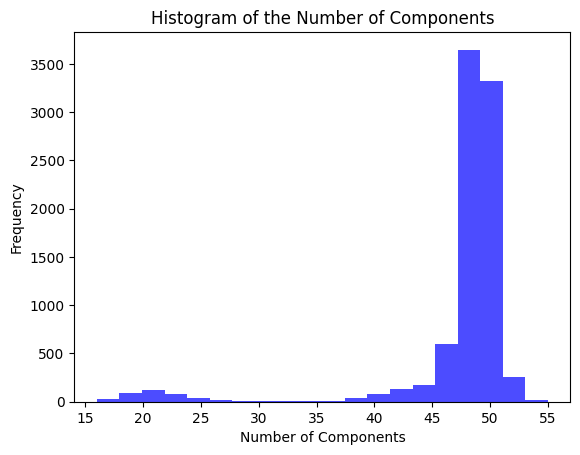

This is the maximum number of components 55
This is the minimum number of components 16


In [97]:
import statistics

statistics.mean(num_comp)

# Plot a histogram
plt.hist(num_comp, bins=20, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Number of Components')
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Components')

# Display the histogram
plt.show()
print('This is the maximum number of components', max(num_comp))
print('This is the minimum number of components', min(num_comp))

Due to the substantial volume of data, Principal Component Analysis (PCA) was performed on each audio file to determine the number of components necessary to account for 85% of the variance in the data.

The resulting values were aggregated and averaged, revealing that approximately 47 components are required to explain the variance in the dataset. Moreover, a graphical representation of these components for each audio clip demonstrated that the majority of audio clips necessitate between 40 and 55 components. This highlights the diverse characteristics and complexities associated with each speaker, reinforcing the challenge of speaker classification.

Interestingly, a subset of audio clips required only around 20 components. This suggests that these particular clips may represent unique vocal patterns, distinct accents, or specific speech characteristics associated with particular speakers.

Overall, the finding that approximately 47 components are sufficient to explain 85% of the variance in the data is a noteworthy advancement in computational efficiency compared to the initial 768 features extracted using the wav2vec encoder.

**Clustering**

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Step 1: Prepare the data
# Assume features_wav2vec is your Wav2Vec features, shape: (num_samples, num_features)
# Assuming x_scale is your feature data
# Reduce dimensionality using PCA
pca = PCA(n_components=47)  # Adjust the number of components as needed
xpca_path='/content/drive/MyDrive/x_pca.pickle'
num_clusters = 40  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

if os.path.exists(xpca_path):
  with open(xpca_path, 'rb') as f:
    x_pca = pickle.load(f)
else:
  X=np.concatenate(X_wav2vec).reshape(-1, 768)
  x_scale = StandardScaler().fit_transform(X)
  x_pca = pca.fit_transform(x_scale)



In [13]:
# Step 3: Apply K-means clustering

num_clusters = 40  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(x_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


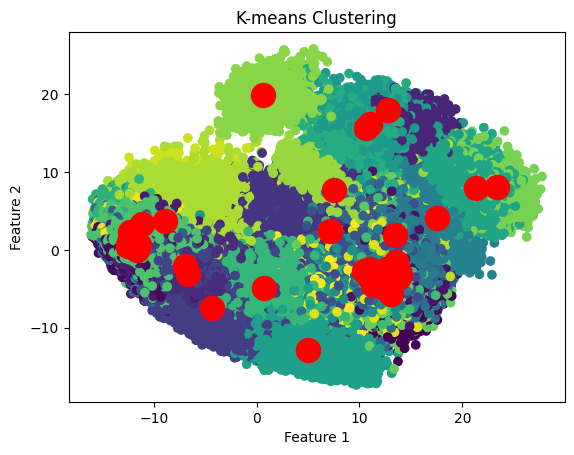

In [12]:
# Optional: Visualize the clusters

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.show()

In this scenario, we utilized the 47 PCA components to reduce the dimensionality of the features, thus making the computational demands more manageable. Subsequently, I employed 40 clusters, each corresponding to a specific speaker, and applied the k-means algorithm to visualize these clusters based on the first two PCA features.

From the visual representation shown in the image above, it becomes evident that relying solely on these two features is insufficient to accurately identify the speaker. However, some clusters appear distinguishable, suggesting that there are speakers with distinct voices for which two features might suffice. This further aligns with our findings from the PCA analysis, which indicated the need for a minimum of 47 features to accurately represent the data.

Regrettably, visualizing the clusters in all 47 dimensions is impractical. Nevertheless, our plot provides a valuable visualization, offering insights into the nature of the data under analysis.